# TGCN Stock Trend Classification - Complete Training Pipeline

A clean, well-organized notebook for training Temporal Graph Convolutional Networks (TGCN) to predict stock trends using inter-stock relationships.

**Overview:**
- Data: 100 stocks with OHLCV data and hybrid graph structure
- Task: 3-class classification (Down/Neutral/Up) based on return thresholds
- Method: TGCN with optional Focal Loss for class imbalance mitigation
- Metrics: Accuracy, Precision, Recall, F1-Score with detailed visualization

## Section 1: Import Libraries and Configuration

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tools.SP100Stock import SP100Stocks
from models import TGCN, train, measure_accuracy
from models.train import FocalLoss
from functools import partial
from datetime import datetime
import os

# Configuration
print("="*70)
print("TGCN STOCK TREND CLASSIFICATION - TRAINING PIPELINE")
print("="*70)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

print("✓ Configuration complete")

TGCN STOCK TREND CLASSIFICATION - TRAINING PIPELINE

✓ Device: cuda
✓ Configuration complete


## Section 2: Data Preprocessing and Loading

In [18]:
def create_labels_3class(sample: Data, threshold: float = 0.0055):
    """
    Transform stock returns into 3-class labels: Down, Neutral, Up
    
    Args:
        sample: Graph data sample from dataset
        threshold: Threshold for neutral zone (default: ±0.55%)
    
    Returns:
        sample with y labels (0=Down, 1=Neutral, 2=Up) and returns
    """
    # Calculate market return (average return across all stocks)
    market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
    
    # Store individual returns for analysis
    sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
    sample.market_return = market_return
    
    # Create 3-class labels
    sample.y = torch.zeros_like(sample.returns, dtype=torch.long).squeeze(1)
    sample.y[sample.returns.squeeze(1) < -threshold] = 0      # Down
    sample.y[(sample.returns.squeeze(1) >= -threshold) & 
             (sample.returns.squeeze(1) <= threshold)] = 1     # Neutral
    sample.y[sample.returns.squeeze(1) > threshold] = 2        # Up
    
    return sample


# Data loading parameters
print("\n" + "="*70)
print("STEP 1: DATA LOADING AND PREPROCESSING")
print("="*70)

threshold = 0.0055  # ±0.55% threshold for neutral zone
weeks_ahead = 1
adj_file = 'hybrid_adj.npy'  # Use hybrid adjacency matrix

print(f"\n✓ Parameters:")
print(f"  - Threshold: ±{threshold*100:.2f}%")
print(f"  - Prediction window: {weeks_ahead} week(s) ahead")
transform = partial(create_labels_3class, threshold=threshold)

# Create dataset with label transformation
transform = partial(create_labels_3class, threshold=threshold)
dataset = SP100Stocks(
    root="data/",
    adj_file_name=adj_file,
    future_window=weeks_ahead,
    force_reload=True,
    transform=transform
)

print(f"\n✓ Dataset loaded: {len(dataset)} samples, {dataset[0].num_nodes} stocks")

# Analyze class distribution
#all_labels = []
#for i in range(len(dataset)):
#    all_labels.extend(dataset[i].y.cpu().numpy())
#
#unique, counts = np.unique(all_labels, return_counts=True)
#class_names = ['Down (0)', 'Up (1)']
#
#print(f"\n✓ Class distribution (overall):")
#for label, count in zip(unique, counts):
#    pct = count / len(all_labels) * 100
#    print(f"  {class_names[label]}: {count:5d} samples ({pct:5.2f}%)")
#
## Verify sample data
#print(f"\n✓ Sample verification (first 5 stocks from first sample):")
#sample = dataset[0]
#for i in range(5):

#    label = int(sample.y[i].item())#    print(f"  Stock {i}: return={ret:+7.2f}%, label={class_names[label]}")
#    ret = sample.returns[i].item() * 100


STEP 1: DATA LOADING AND PREPROCESSING

✓ Parameters:
  - Threshold: ±0.55%
  - Prediction window: 1 week(s) ahead
Loading and processing data for PyG format...
Values DataFrame shape: (70300, 14)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 100
Adjacency matrix shape: (100, 100)
Number of nodes (from adj): 100
Number of edges: 720
Unique symbols count: 100
Unique dates count: 703

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 13
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD', 'Intraday_Volatility', 'Intraday_Momentum', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']


Processing...


Pivoted shape (Date x Symbol): (703, 100)

Final array shapes:
  x (features): (100, 703, 13)
  close_prices: (100, 703)
  Expected x shape: (nodes_nb=100, timestamps_nb=703, features_nb=13)
  After transpose: x shape = torch.Size([100, 13, 703])
  Expected: (nodes_nb=100, features_nb=13, timestamps_nb=703)

Building edge index and edge weights...
  Created 720 edges



Done!



✓ Dataset loaded: 677 samples, 100 stocks


## Section 3: Model Architecture and Hyperparameters

In [19]:
# Split dataset into train and test
print("\n" + "="*70)
print("STEP 2: TRAIN/TEST SPLIT")
print("="*70)

train_ratio = 0.9
batch_size = 32

train_size = int(train_ratio * len(dataset))
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"\n✓ Train/test split:")
print(f"  - Training samples: {len(train_dataset)} ({train_ratio*100:.1f}%)")
print(f"  - Test samples: {len(test_dataset)} ({(1-train_ratio)*100:.1f}%)")
print(f"  - Batch size: {batch_size}")
print(f"  - Train batches: {len(train_dataloader)}")
print(f"  - Test batches: {len(test_dataloader)}")


STEP 2: TRAIN/TEST SPLIT

✓ Train/test split:
  - Training samples: 609 (90.0%)
  - Test samples: 68 (10.0%)
  - Batch size: 32
  - Train batches: 20
  - Test batches: 1


In [20]:
print("\n" + "="*70)
print("STEP 3: MODEL ARCHITECTURE AND HYPERPARAMETERS")
print("="*70)

# Model architecture parameters
in_channels = dataset[0].x.shape[-2]  # Input feature dimension
out_channels = 3                        # 3-class output (Down, Neutral, Up)
hidden_size = 16                        # Hidden state size for TGCN
layers_nb = 2                           # Number of TGCN layers
use_gat = True                          # Use GAT instead of GCN

# Training hyperparameters
lr = 0.005                              # Learning rate
weight_decay = 1e-5                     # L2 regularization
num_epochs = 100                        # Number of training epochs
use_focal_loss = True                   # Use Focal Loss for class imbalance

print(f"\n✓ Model Architecture:")
print(f"  - Input channels: {in_channels}")
print(f"  - Output channels: {out_channels}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - Layers: {layers_nb}")
print(f"  - Graph attention: {use_gat}")

print(f"\n✓ Training Hyperparameters:")
print(f"  - Learning rate: {lr}")
print(f"  - Weight decay (L2): {weight_decay}")
print(f"  - Epochs: {num_epochs}")
print(f"  - Focal Loss: {use_focal_loss}")

# Initialize model
model = TGCN(
    in_channels=in_channels,
    out_channels=out_channels,
    hidden_size=hidden_size,
    layers_nb=layers_nb,
    use_gat=use_gat
)

print(f"\n✓ Model initialized: {model.__class__.__name__}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define loss function
if use_focal_loss:
    class_weights = torch.tensor([1.5, 0.3, 1.5], dtype=torch.float32)
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    loss_name = "Focal Loss"
else:
    criterion = nn.CrossEntropyLoss()
    loss_name = "CrossEntropyLoss"

print(f"\n✓ Loss function: {loss_name}")

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print(f"✓ Optimizer: Adam")

# Move to device
model = model.to(device)
criterion = criterion.to(device)
print(f"\n✓ Model and criterion moved to device: {device}")


STEP 3: MODEL ARCHITECTURE AND HYPERPARAMETERS

✓ Model Architecture:
  - Input channels: 13
  - Output channels: 3
  - Hidden size: 16
  - Layers: 2
  - Graph attention: True

✓ Training Hyperparameters:
  - Learning rate: 0.005
  - Weight decay (L2): 1e-05
  - Epochs: 100
  - Focal Loss: True

✓ Model initialized: TGCN
  - Total parameters: 5,651

✓ Loss function: Focal Loss
✓ Optimizer: Adam

✓ Model and criterion moved to device: cuda


## Section 4: Training Loop

In [21]:
print("\n" + "="*70)
print("STEP 4: TRAINING")
print("="*70)

# Verify device placement before training
print(f"\n✓ Device verification:")
print(f"  - Model on: {next(model.parameters()).device}")
if hasattr(criterion, 'alpha') and criterion.alpha is not None:
    print(f"  - Criterion alpha on: {criterion.alpha.device}")

# Create run directory for saving results
run_name = f"TGCN_3class_{datetime.now().strftime('%d_%m_%Hh%M')}"
run_dir = f"runs/{run_name}"
os.makedirs(run_dir, exist_ok=True)

print(f"\n✓ Run directory: {run_dir}")
print(f"\nStarting training... (this may take a while)")

# Train model
train_losses, test_losses = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    task_title=f"TGCN_3class",
    measure_acc=True
)

print(f"\n✓ Training complete!")
print(f"  - Final training loss: {train_losses[-1]:.4f}")
print(f"  - Final test loss: {test_losses[-1]:.4f}")


STEP 4: TRAINING

✓ Device verification:
  - Model on: cuda:0
  - Criterion alpha on: cuda:0

✓ Run directory: runs/TGCN_3class_22_01_16h07

Starting training... (this may take a while)


Epochs: 100%|██████████| 100/100 [25:07<00:00, 15.07s/it, Batch=100.0%]


✓ Training complete!
  - Final training loss: 0.4073
  - Final test loss: 0.4273


In [22]:
# Save model
model_save_path = f"models/saved_models/{run_name}_{model.__class__.__name__}.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"\n✓ Model saved to: {model_save_path}")


✓ Model saved to: models/saved_models/TGCN_3class_22_01_16h07_TGCN.pt


## Section 5: Model Evaluation

In [23]:
print("\n" + "="*70)
print("STEP 5: MODEL EVALUATION")
print("="*70)

# Evaluation on test set
model.eval()
test_data = next(iter(test_dataloader))
test_data = test_data.to(device)

with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    probs = F.softmax(logits, dim=-1)  # Softmax for 3-class
    predictions = probs.argmax(dim=-1)
    actual = test_data.y.squeeze()

# Flatten for metrics
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
probs_max = probs.max(dim=-1)[0].cpu().numpy().flatten()

# Get per-class probabilities (3 classes)
probs_down = probs[:, 0].cpu().numpy().flatten()
probs_neutral = probs[:, 1].cpu().numpy().flatten()
probs_up = probs[:, 2].cpu().numpy().flatten()

# Calculate metrics
accuracy = (preds_flat == actuals_flat).mean()
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down', 'Neutral', 'Up'],
                               output_dict=True)

print(f"\n✓ Test Set Evaluation:")
print(f"  - Overall Accuracy: {accuracy:.2%}")
print(f"\n  Per-Class Metrics:")
for class_name in ['Down', 'Neutral', 'Up']:
    p = report[class_name]['precision']
    r = report[class_name]['recall']
    f1 = report[class_name]['f1-score']
    print(f"    {class_name:8s}: Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}")

print(f"\n  Macro Average: Precision={report['macro avg']['precision']:.3f}, "
      f"Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")

# Class distribution analysis
print(f"\n✓ Prediction vs Actual Distribution:")
actual_counts = np.bincount(actuals_flat, minlength=3)
pred_counts = np.bincount(preds_flat, minlength=3)
for i, name in enumerate(['Down', 'Neutral', 'Up']):
    print(f"  {name:8s}: Actual={actual_counts[i]:5d} ({actual_counts[i]/len(actuals_flat)*100:5.1f}%), "
          f"Predicted={pred_counts[i]:5d} ({pred_counts[i]/len(preds_flat)*100:5.1f}%)")


STEP 5: MODEL EVALUATION

✓ Test Set Evaluation:
  - Overall Accuracy: 34.25%

  Per-Class Metrics:
    Down    : Precision=0.319, Recall=0.280, F1=0.299
    Neutral : Precision=0.000, Recall=0.000, F1=0.000
    Up      : Precision=0.351, Recall=0.718, F1=0.472

  Macro Average: Precision=0.224, Recall=0.333, F1=0.257

✓ Prediction vs Actual Distribution:
  Down    : Actual= 2152 ( 31.6%), Predicted= 1888 ( 27.8%)
  Neutral : Actual= 2243 ( 33.0%), Predicted=    0 (  0.0%)
  Up      : Actual= 2405 ( 35.4%), Predicted= 4912 ( 72.2%)


/home/alrodriguezg/U/s5/gnn/GNN_paper/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alrodriguezg/U/s5/gnn/GNN_paper/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alrodriguezg/U/s5/gnn/GNN_paper/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Section 6: Results Visualization


STEP 6: VISUALIZATION


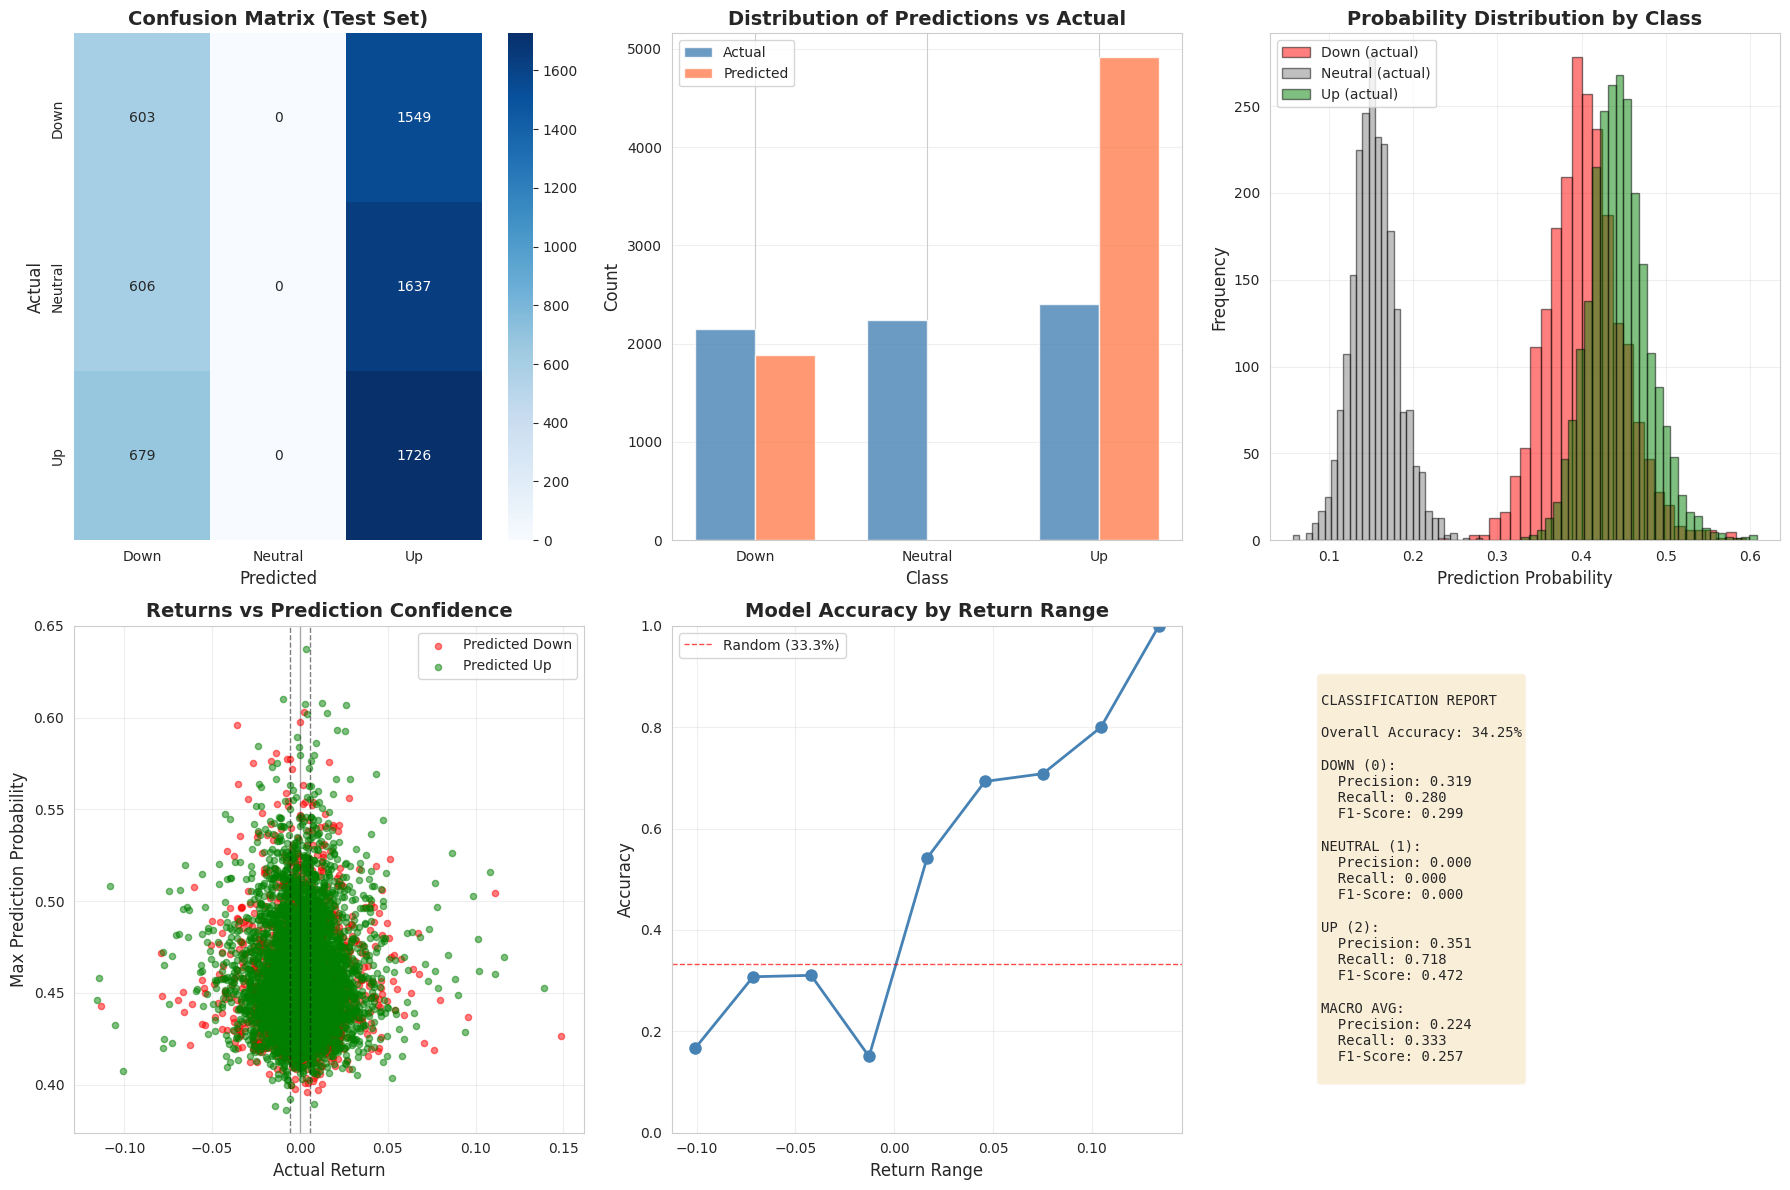


✓ Visualization saved to: runs/TGCN_3class_22_01_16h07/evaluation_results.png


In [24]:
print("\n" + "="*70)
print("STEP 6: VISUALIZATION")
print("="*70)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat, labels=[0, 1, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=3)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=3)
x = np.arange(3)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down', 'Neutral', 'Up'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Probability Distributions by Class
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_down[actuals_flat == 0], bins=30, alpha=0.5, label='Down (actual)', color='red', edgecolor='black')
ax3.hist(probs_neutral[actuals_flat == 1], bins=30, alpha=0.5, label='Neutral (actual)', color='gray', edgecolor='black')
ax3.hist(probs_up[actuals_flat == 2], bins=30, alpha=0.5, label='Up (actual)', color='green', edgecolor='black')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Probability Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
colors_map = {0: 'red', 1: 'gray', 2: 'green'}
labels_map = {0: 'Down', 1: 'Neutral', 2: 'Up'}
for class_idx in [0, 1, 2]:
    mask = (preds_flat == class_idx)
    if mask.sum() > 0:
        ax4.scatter(returns_flat[mask], probs_max[mask],
                   alpha=0.5, label=f'Predicted {labels_map[class_idx]}',
                   color=colors_map[class_idx], s=20)
ax4.axvline(x=-threshold, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=threshold, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Max Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Confidence', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=1/3, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (33.3%)')
ax5.set_xlabel('Return Range', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report_text = f"""
CLASSIFICATION REPORT

Overall Accuracy: {accuracy:.2%}

DOWN (0):
  Precision: {report['Down']['precision']:.3f}
  Recall: {report['Down']['recall']:.3f}
  F1-Score: {report['Down']['f1-score']:.3f}

NEUTRAL (1):
  Precision: {report['Neutral']['precision']:.3f}
  Recall: {report['Neutral']['recall']:.3f}
  F1-Score: {report['Neutral']['f1-score']:.3f}

UP (2):
  Precision: {report['Up']['precision']:.3f}
  Recall: {report['Up']['recall']:.3f}
  F1-Score: {report['Up']['f1-score']:.3f}

MACRO AVG:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f"{run_dir}/evaluation_results.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {run_dir}/evaluation_results.png")